# Homework 1 - Time Series

This notebook contains all code required for Homework 1.
Use the markdown sections to add your written analysis and conclusions.


In [2]:
%pip install -q pandas matplotlib seaborn xlrd openpyxl


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)


## Part 1: Impact of September 11 on U.S. Travel


In [4]:
travel_path = "../resources/Sept11Travel.xls"

try:
    travel = pd.read_excel(travel_path)
except Exception:
    # Fallback in case file extension/engine differs on another machine
    travel = pd.read_excel(travel_path, engine="xlrd")

travel.columns = [str(col).strip() for col in travel.columns]
travel.head()


,Month,Air RPM (000s),Rail PM,Car (billions)
0,1990-01-01,35153577,454115779,163.275384
1,1990-02-01,32965187,435086002,153.254409
2,1990-03-01,39993913,568289732,178.417577
3,1990-04-01,37981886,568101697,178.680686
4,1990-05-01,38419672,539628385,188.876171


In [5]:
# Build a monthly date index if one is not already present
if "Month" in travel.columns:
    travel["Month"] = pd.to_datetime(travel["Month"])
    travel = travel.set_index("Month")
elif "Date" in travel.columns:
    travel["Date"] = pd.to_datetime(travel["Date"])
    travel = travel.set_index("Date")
else:
    travel.index = pd.date_range(start="1990-01-01", periods=len(travel), freq="MS")

# Normalize expected column names
rename_map = {}
for col in travel.columns:
    lower = col.lower()
    if "air" in lower:
        rename_map[col] = "Air"
    elif "rail" in lower:
        rename_map[col] = "Rail"
    elif "car" in lower or "vehicle" in lower:
        rename_map[col] = "Car"

travel = travel.rename(columns=rename_map)
series_cols = [c for c in ["Air", "Rail", "Car"] if c in travel.columns]
travel = travel[series_cols].dropna()
travel.head()


,Air,Rail,Car
Month,,,
1990-01-01,35153577,454115779,163.275384
1990-02-01,32965187,435086002,153.254409
1990-03-01,39993913,568289732,178.417577
1990-04-01,37981886,568101697,178.680686
1990-05-01,38419672,539628385,188.876171


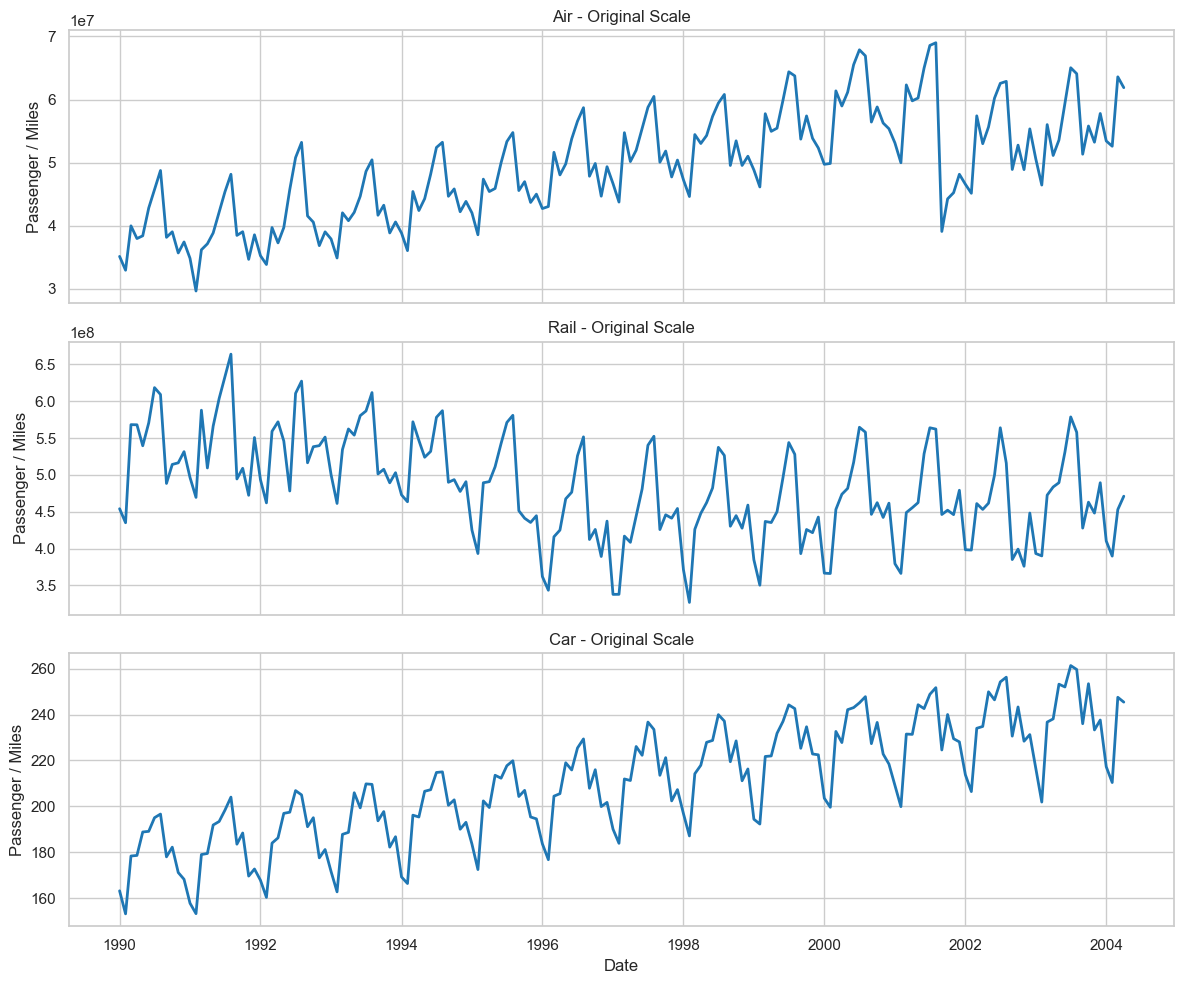

In [6]:
# Plot each of the three original series
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 10))
for ax, col in zip(axes, series_cols):
    ax.plot(travel.index, travel[col], color="#1f77b4", linewidth=2)
    ax.set_title(f"{col} - Original Scale")
    ax.set_ylabel("Passenger / Miles")

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()


### Analysis space (original-scale trends)

It seems that car and airline ravels are moving upward while trains are on their way out already, there also seems to be a lot of seasonality with a consistent 2 spikes per year for all modes of transport. Thus, the data suggest there the use of cars and plans are increasing while trains are being used less each year. However, train travel seems to sightly increase after 1998. There is also a sharp decline in plane travel between 2000 and 2002. This is likely due to 9/11.


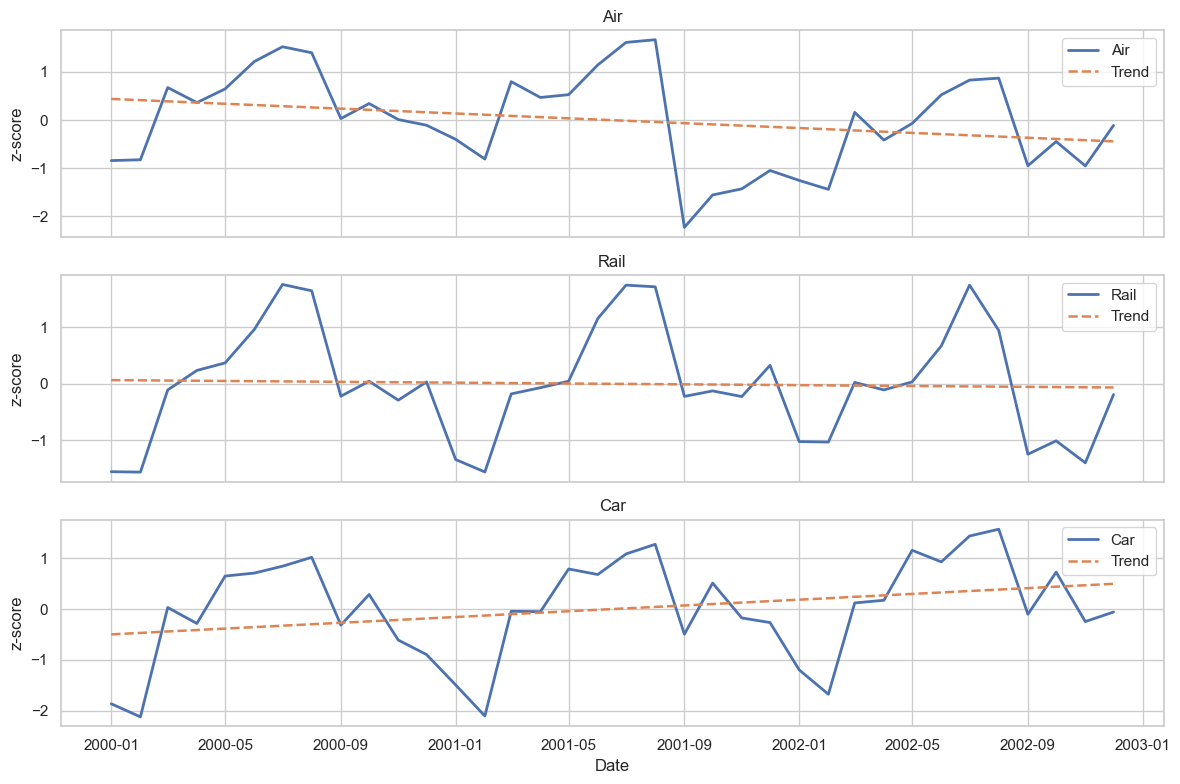

In [17]:

# FILTER 
travel = travel.loc["1998-01-01":"2004-12-31"].copy()


# Z-score scaling
scaled = (travel - travel.mean()) / travel.std()

# ensure numeric numpy arrays for polyfit (type-checkers require ArrayLike[complex])
x = np.arange(len(scaled)).astype(float)

fig, axes = plt.subplots(
    nrows=len(scaled.columns),
    ncols=1,
    figsize=(12, 8),
    sharex=True
)

for ax, col in zip(axes, scaled.columns):
    y = scaled[col].to_numpy(dtype=float)

    # Linear trend
    coeffs = np.polyfit(x, y, 1)
    trend = np.poly1d(coeffs)(x)

    ax.plot(scaled.index, y, linewidth=2, label=col)
    ax.plot(scaled.index, trend, linestyle="--", linewidth=1.8, label="Trend")

    ax.set_title(col)
    ax.set_ylabel("z-score")
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()


### Analysis space (scaled series + trendlines)

Write any new observations you notice after scaling and adding trendlines here.


## Part 2: Forecasting Department Store Sales


In [21]:
sales_path = "../resources/DepartmentStoreSales.csv"
sales = pd.read_csv(sales_path)
sales.columns = [str(c).strip() for c in sales.columns]
sales.head()


,Quarter,Sales
0,1,50147
1,2,49325
2,3,57048
3,4,76781
4,5,48617


In [23]:
# Build a quarterly datetime index
if "Quarter" in sales.columns:
    sales["Quarter"] = sales["Quarter"].astype(str).str.replace(" ", "", regex=False)
    # Accept formats like Q1-2018 or 2018 Q1
    q = sales["Quarter"].str.extract(r"(?:(Q[1-4]).*?(\d{4})|(\d{4}).*?(Q[1-4]))")
    q_label = q[0].fillna(q[3])
    year = q[1].fillna(q[2])
    sales_index = pd.PeriodIndex(year + q_label, freq="Q").to_timestamp()
    sales = sales.set_index(sales_index)
elif "Date" in sales.columns:
    sales["Date"] = pd.to_datetime(sales["Date"])
    sales = sales.set_index("Date")
else:
    sales.index = pd.period_range(start="2000Q1", periods=len(sales), freq="Q").to_timestamp()

# Identify sales column
sales_col = None
for c in sales.columns:
    if "sale" in c.lower():
        sales_col = c
        break
if sales_col is None:
    sales_col = sales.columns[-1]

sales_series = sales[sales_col].astype(float)
sales_series.head()


NaT    50147.0
NaT    49325.0
NaT    57048.0
NaT    76781.0
NaT    48617.0
Name: Sales, dtype: float64

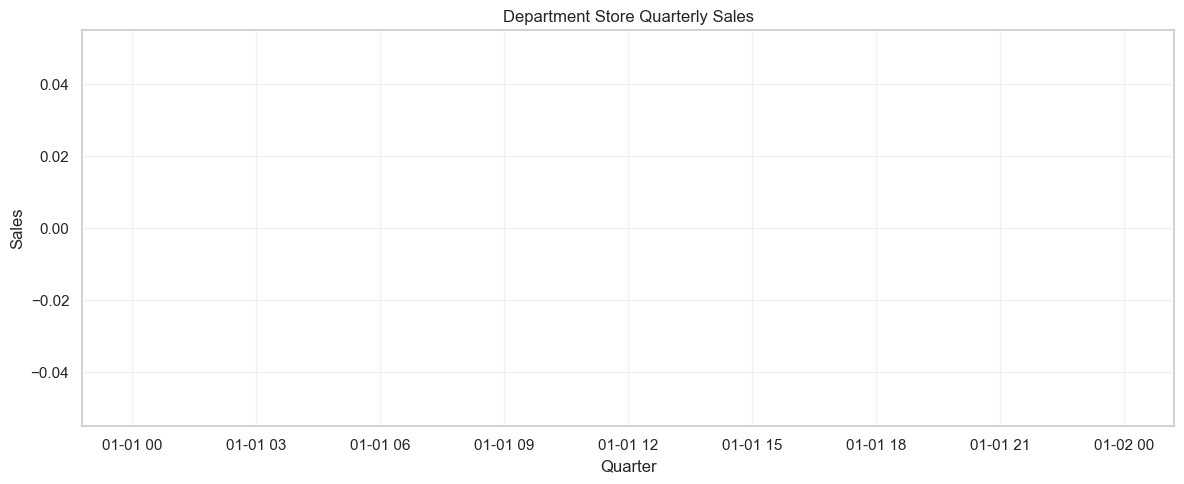

In [ ]:
# Well-formatted quarterly sales plot
fig, ax = plt.subplots(figsize=(12, 5))
x = sales_series.index.to_numpy()
y = sales_series.to_numpy(dtype=float)
ax.plot(x, y, marker="o", linewidth=2, color="#2ca02c")
ax.set_title("Department Store Quarterly Sales")
ax.set_xlabel("Quarter")
ax.set_ylabel("Sales")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()


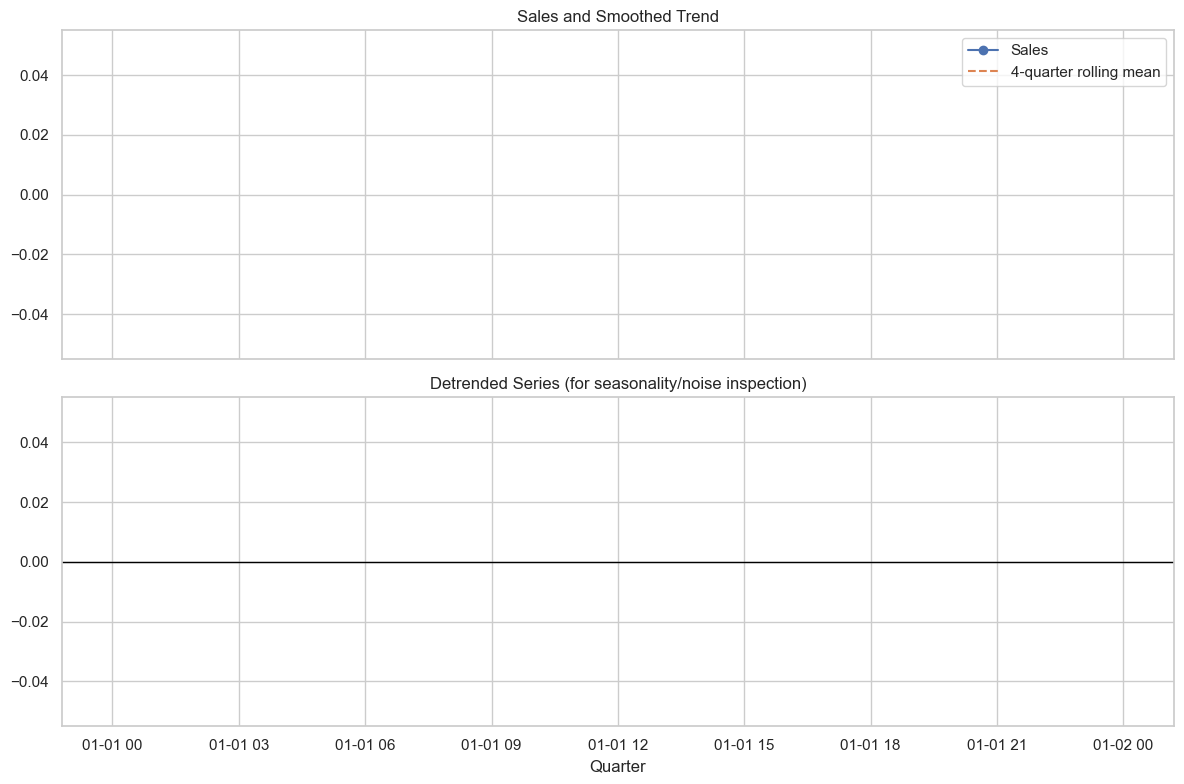

In [24]:
# Quick decomposition-style helpers for trend/seasonality discussion
sales_df = sales_series.to_frame(name="sales")
sales_df["rolling_mean_4"] = sales_df["sales"].rolling(window=4).mean()
sales_df["detrended"] = sales_df["sales"] - sales_df["rolling_mean_4"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(sales_df.index, sales_df["sales"], marker="o", label="Sales")
axes[0].plot(sales_df.index, sales_df["rolling_mean_4"], linestyle="--", label="4-quarter rolling mean")
axes[0].set_title("Sales and Smoothed Trend")
axes[0].legend()

axes[1].plot(sales_df.index, sales_df["detrended"], marker="o", color="#d62728")
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("Detrended Series (for seasonality/noise inspection)")
axes[1].set_xlabel("Quarter")

plt.tight_layout()
plt.show()


### Analysis space (trend, seasonality, noise)

Discuss which components seem present in the quarterly sales series and why.
